In [265]:
import numpy as np
import pandas as pd
from math import ceil, sqrt
from ast import literal_eval
from itertools import product
from random import choices, random, randrange, sample

import networkx as nx
from scipy.stats import norm


In [273]:
## Create ApplicationDF(appdf)
## Get app resource usage
appdf = pd.read_csv("app_resources.csv", names=["app_id", "cpu", "memory"], usecols=[0,1,2])
appdf.app_id = appdf.app_id.apply(lambda x: int(x.split('_')[1]))

appdf["cpu_T"] = appdf.cpu.apply(lambda x: [ float(i) for i in x.split('|')][0])
appdf["memory_T"] = appdf.memory.apply(lambda x: [ float(i) for i in x.split('|')][0])
appdf["cpu"] = appdf.cpu.apply(lambda x: [ float(i) for i in x.split('|')]).apply(max).apply(ceil)
appdf["memory"] = appdf.memory.apply(lambda x: [ float(i) for i in x.split('|')]).apply(max).apply(ceil)

appdf.set_index("app_id", inplace=True)
appdf.head(5)

,cpu,memory,cpu_T,memory_T
app_id,,,,
1,1,8,0.500000,8.000000
2,1,8,0.500000,8.000000
3,1,8,0.500000,8.000000
4,1,8,0.500000,1.208855
5,2,8,0.583833,8.000000


In [325]:
## Create nodedf
## Get resource size of each node
nodedf = pd.read_csv("machine_resources.csv",names=["node_id","cpu","memory"],usecols=[0,1,2])
nodedf.node_id = nodedf.node_id.apply(lambda x: int(x.split('_')[1]))
nodedf.set_index("node_id", inplace=True)
len(nodedf)

6000

In this case the node is like bin as the bin packing problem, i.e. the same capacity in all dimensions (cpu and memory usage)

In [303]:
## Create instancedf
## Get number of instances of each application

instancedf = pd.read_csv("instance_deploy.csv", names=['inst_id', 'app_id', 'machine_id'])
instancedf['app_id'] = instancedf['app_id'].apply(lambda x: int(x.split('_')[1]))

analdf=instancedf.dropna().copy()
instancedf.drop(['machine_id'], axis=1, inplace=True)

appdf["instance_num"] = instancedf.groupby(['app_id']).count()
appdf.head(5)

,cpu,memory,cpu_T,memory_T,instance_num
app_id,,,,,
1,1,8,0.500000,8.000000,1
2,1,8,0.500000,8.000000,1
3,1,8,0.500000,8.000000,4
4,1,8,0.500000,1.208855,2
5,2,8,0.583833,8.000000,18


## Usage Analysis

In [228]:
analdf=pd.merge(analdf,appdf,on='app_id')
# analdf.drop('instance_num',axis=0, inplace=True)
# analdf

In [229]:
analdf.drop('instance_num',axis=1, inplace=True)
analdf

,inst_id,app_id,machine_id,cpu,memory,cpu_T,memory_T
0,inst_40570,3283,machine_4726,6,8,2.940820,8.0
1,inst_7089,3283,machine_4356,6,8,2.940820,8.0
2,inst_70501,3283,machine_3628,6,8,2.940820,8.0
3,inst_92814,3283,machine_4630,6,8,2.940820,8.0
4,inst_84067,3283,machine_2224,6,8,2.940820,8.0
...,...,...,...,...,...,...,...
61249,inst_55271,4485,machine_3857,1,8,0.500000,8.0
61250,inst_37903,1098,machine_4273,1,8,0.500000,8.0
61251,inst_12816,5392,machine_3251,1,1,0.500000,1.0
61252,inst_5943,324,machine_5579,1,8,0.500000,8.0


In [269]:
machine_usage = pd.DataFrame()
machine_usage["machine_id"]=analdf["machine_id"].unique()
cpu_sum=analdf.groupby("machine_id")["cpu_T"].sum()
memory_sum=analdf.groupby("machine_id")["memory_T"].sum()
machine_usage=pd.merge(machine_usage,cpu_sum,on='machine_id')
machine_usage=pd.merge(machine_usage,memory_sum,on='machine_id')

machine_usage.rename(columns={"cpu_T":"cpu_usage","memory_T":"memory_usage"},inplace=True)
machine_usage["cpu_usage"]=machine_usage["cpu_usage"].apply(lambda x: x/(32)*100)
machine_usage["memory_usage"]=machine_usage["memory_usage"].apply(lambda x: x/(64)*100)
machine_usage['machine_id'] = machine_usage['machine_id'].apply(lambda x: int(x.split('_')[1]))
machine_usage

,machine_id,cpu_usage,memory_usage
0,4726,286.109525,360.613275
1,4356,217.734834,340.923264
2,3628,190.963903,354.745584
3,4630,138.400716,362.594439
4,2224,45.983734,92.720503
...,...,...,...
4035,1004,35.485428,75.000000
4036,1382,14.183312,79.672558
4037,2986,22.154688,60.926422
4038,2717,3.482291,25.000000


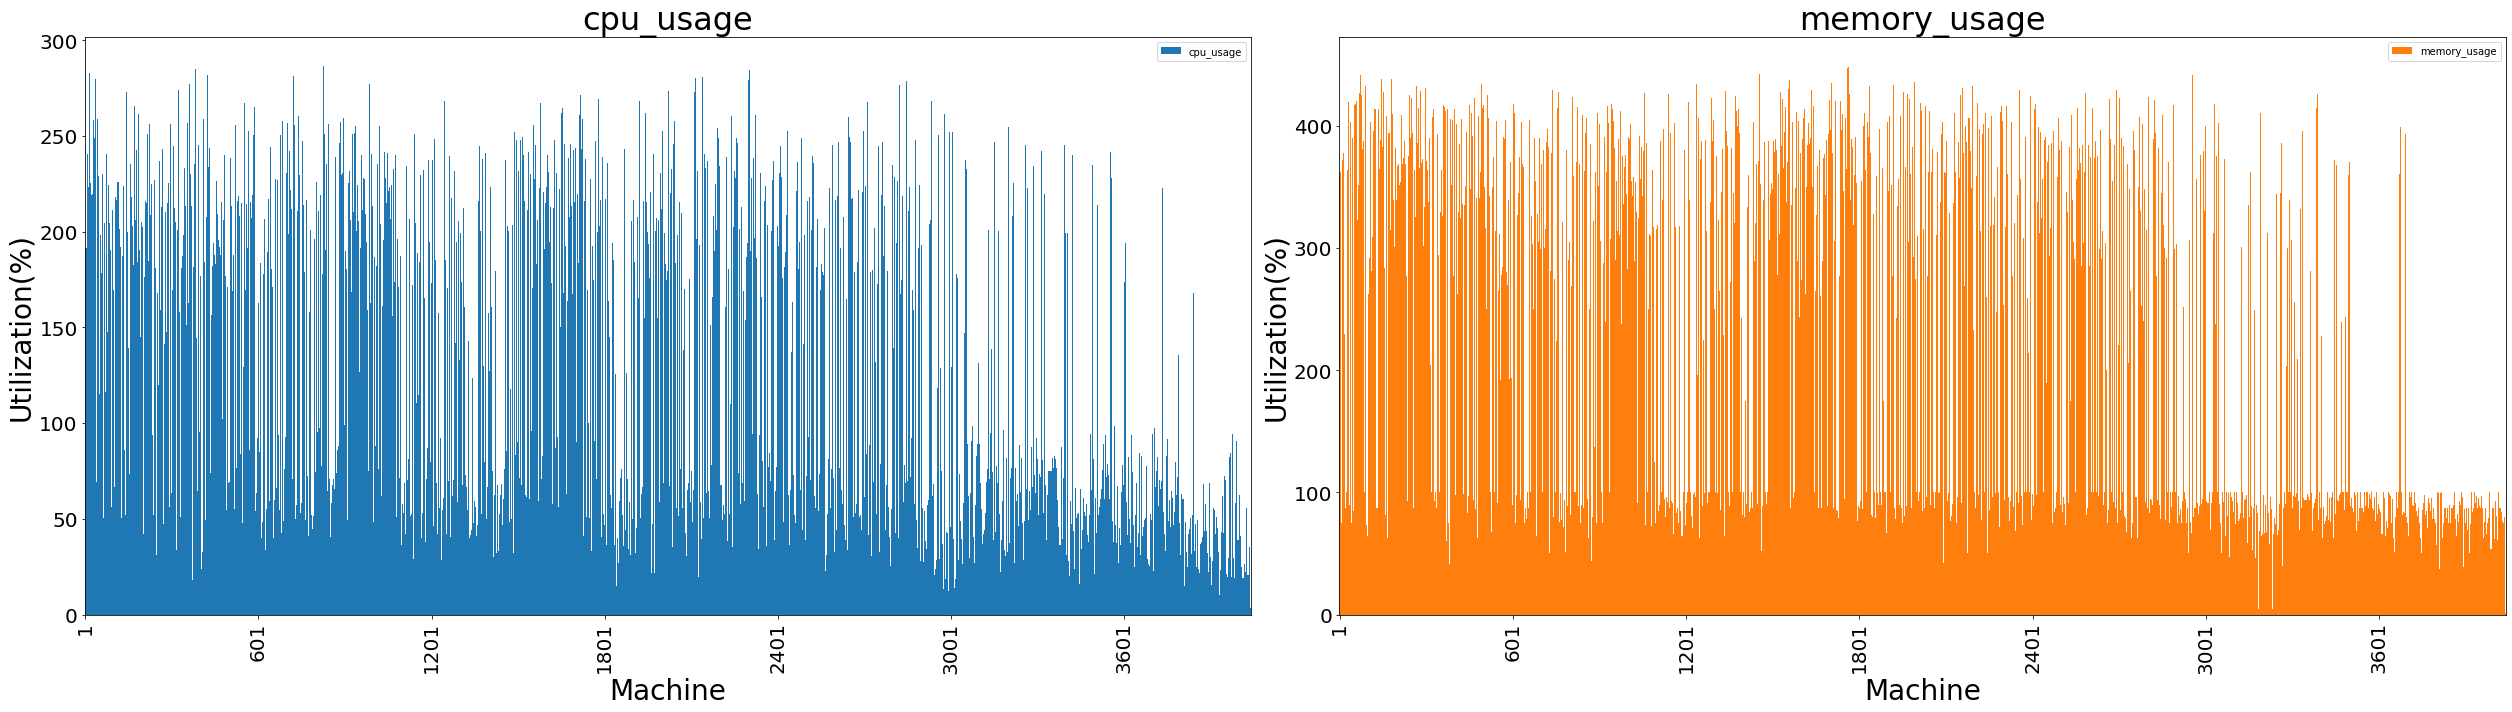

In [270]:
import matplotlib
machine_anal=machine_usage.copy()
machine_anal.drop('machine_id',axis=1, inplace=True)
machine_anal.plot(kind='bar',xlabel = 'Machine', ylabel='Utilization(%)',figsize=(35,10), xticks= range(1,4200,600), width=1.0, subplots=True, layout=(1,2), fontsize=20)

# plt.ylabel('usage_ratio', fontsize=20)
# plt.xlabel('machine_id', fontsize=20)
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'axes.labelsize' : '28',
          'ytick.labelsize':'24'}
matplotlib.rcParams.update(params)
#show plot result
plt.tight_layout()
plt.show()

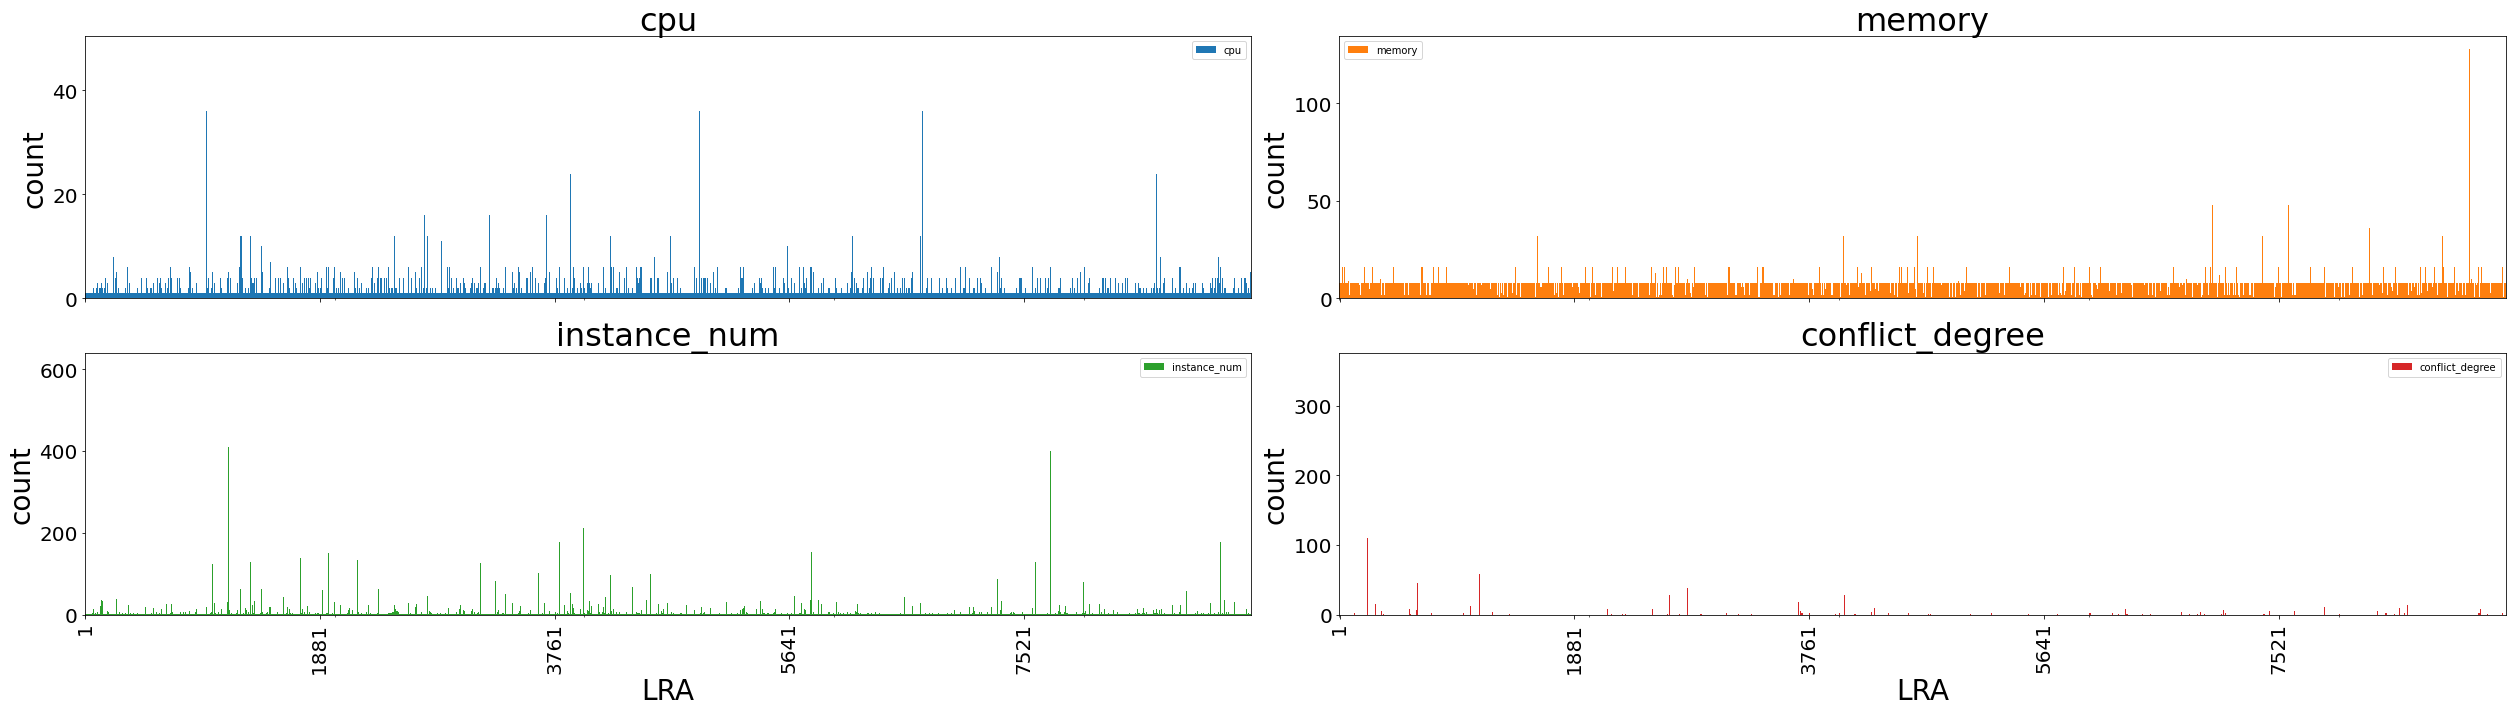

In [268]:
fanal=normal.copy()
# fanal.drop('app_id',axis=1, inplace=True)
fanal.drop('conflict',axis=1, inplace=True)

fanal.plot(kind='bar',xlabel = 'LRA', ylabel='count',figsize=(35,10), xticks= range(1,9400,1880), width=1.0, subplots=True, layout=(2,2), fontsize=20)
plt.tight_layout()
plt.show()

## Data processing

In [305]:
# Create conflictdf
# Compute conflicts between applications

conflictdf = pd.read_csv("app_interference.csv", names=['app_a', 'app_b', 'k'])
conflictdf.app_a = conflictdf.app_a.apply(lambda x: int(x.split('_')[1]))
conflictdf.app_b = conflictdf.app_b.apply(lambda x: int(x.split('_')[1]))

# remove instances cannot place into the same node
dfconflict = conflictdf.query('k==0 & app_a!=app_b')


# select instances piar that have conflict and calculate conlict degree
conflict_dict = {}

for app_id in conflictdf.app_a.unique():
    a={}
    if app_id in dfconflict.app_a:
        check = dfconflict[dfconflict.app_a==app_id]
        b=list(check["app_b"])
        c=list(check["k"])
        a["conflict"] = list(zip(b,c))
    else:
        a["conflict"] = []
    a["conflict_degree"]=len(a["conflict"])
    conflict_dict[app_id] =  a

normal = appdf.join(pd.DataFrame.from_dict(conflict_dict, orient='index'))
normal

,cpu,memory,cpu_T,memory_T,instance_num,conflict,conflict_degree
app_id,,,,,,,
1,1,8,0.500000,8.000000,1,[],0
2,1,8,0.500000,8.000000,1,[],0
3,1,8,0.500000,8.000000,4,[],0
4,1,8,0.500000,1.208855,2,[],0
5,2,8,0.583833,8.000000,18,[],0
...,...,...,...,...,...,...,...
9334,4,8,2.348981,8.000000,7,[],0
9335,5,8,3.952277,8.000000,1,[],0
9336,1,2,0.500000,1.230658,8,[],0


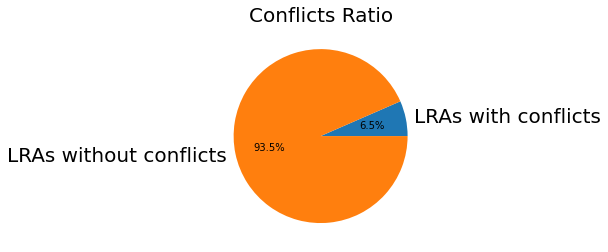

In [291]:
labels = ['LRAs with conflicts','LRAs without conflicts']
conflictslen=len(normal[normal.conflict_degree!=0])
totallen=len(normal)
nums=[conflictslen,totallen-conflictslen]
plt.pie(nums,labels=labels,autopct='%1.1f%%')
plt.title('Conflicts Ratio',fontsize=20)

params = {'axes.titlesize':'20',
          'xtick.labelsize':'20',
          'axes.labelsize' : '20',
          'ytick.labelsize':'20'}
matplotlib.rcParams.update(params)
plt.show()

In [319]:
# outfile_2D = "TClab_dataset_2D1.csv"
# columns = ['nb_instances', 'core', 'memory', 'inter_degree', 'inter_aff']
# normal.to_csv(outfile_2D, sep='\t', columns=columns, encoding='utf-8')
final1 = normal.copy()
final1.drop('cpu_T',axis=1, inplace=True)
final1.drop('memory_T',axis=1, inplace=True)

final1

,cpu,memory,instance_num,conflict,conflict_degree
app_id,,,,,
1,1,8,1,[],0
2,1,8,1,[],0
3,1,8,4,[],0
4,1,8,2,[],0
5,2,8,18,[],0
...,...,...,...,...,...
9334,4,8,7,[],0
9335,5,8,1,[],0
9336,1,2,8,[],0


In [324]:
columns = ['cpu', 'memory','instance_num', 'conflict', 'conflict_degree']
final1.to_csv("processed_data.csv", sep='\t', columns=columns, encoding='utf-8')
# final1